In [55]:
using QuantumOptics
using PyPlot
using DifferentialEquations
using CollectiveSpins
using CurveFit
using Random

In [56]:
function H_RWA(t, psi)
    H_RWA = ω0/2*Jz - (Ω_rabi*exp(-1im*ωl*t)*Jp + conj(Ω_rabi)*exp(1im*ωl*t)*Jm)
    #return H_RWA + compute_H_SFE(N, bMB, Ω_CS), J, dagger.(J), zeros(N, N)#Γ_CS
    return H_RWA+compute_H_SFE(N, bMB, Ω_CS./3), J, dagger.(J), Γ_CS./3#./10#Γ_CS + compute_H_SFE(N, bMB, Ω_CS)
end

function H_RWA_detuning(t, psi)
    H0 = sum([random_frequencies(random_freq, ω0, t)[i]/2*embed(bMB, i, sp*sm) for i = 1:N]) - sum([ω0/2*embed(bMB, i, sm*sp) for i = 1:N])#random_frequencies(random_freq, ω0, t)[i]
    H_RWA =  - (Ω_rabi*exp(-1im*ωl*t)*Jp + conj(Ω_rabi)*exp(1im*ωl*t)*Jm)
    #return H0 + H_RWA +compute_H_SFE(N, bMB, Ω_CS), J, dagger.(J), zeros(N, N)#Γ_CS #zeros(N, N) #+ compute_H_SFE(N, bMB, Ω_CS)
    return H0 + H_RWA + compute_H_SFE(N, bMB, Ω_CS./3), J, dagger.(J), Γ_CS./3#./10#Γ_CS #zeros(N, N) #+ compute_H_SFE(N, bMB, Ω_CS) +compute_H_SFE(N, bMB, Ω_CS)

end

""" Compute the spin flip exchange hamiltonian """
function compute_H_SFE(N, bMB, Ω_CSC)
    H = SparseOperator(bMB)
    for i=1:N, j=1:N
        if i==j
            continue
        end
        H += Ω_CSC[i, j] * embed(bMB, i, sp)*embed(bMB, j, sm)
    end
    return H
end

function random_frequencies(random_freq, ω0, t)
    ω0_array = zeros(N)
    for i = 1:N
        for j = 1:nbr_random_freq
            ω0_array[i] += 5*sin(random_freq[i, j]*t)
        end
    end
    return ω0 .+ ω0_array./length(random_freq[1, :])
end

random_frequencies (generic function with 1 method)

In [57]:
# Define geometry of system
Nx,Ny,Nz = [2,2,2]
N = Nx*Ny*Nz
d_xy, d_z = 266., 532. # Optical lattice spacing in nm
e = [0,0,1]   # Quantization axis
Γ0 = 1. # In Hz

λ = 1299.

a,b,c = [d_xy,d_xy,d_z]/λ
geo = geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
system = SpinCollection(geo, e, gammas=1.)

d_eg = 1.0
E0 = 1.0 + 0im
ωl = 10
ω0 = 11
Ω_rabi = d_eg*E0

Tstep, Tend = 1e-3, 10 # Normalised by Γ0
T = [0:Tstep:Tend;];

In [58]:
# Adding random frequencies
nbr_random_freq = 10
random_freq = randn(N, nbr_random_freq)*10; # White noise

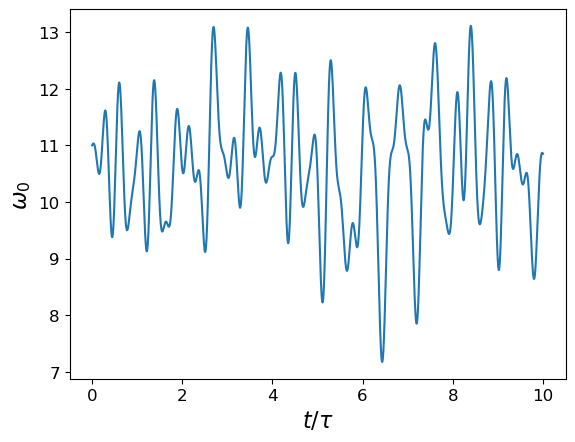

In [59]:
close("all")
figure()
PyPlot.rc("font", size = 12)
plot(T, [random_frequencies(random_freq, ω0, t)[1] for t in T])

xlabel(L"t/\tau", fontsize=16)
ylabel(L"\omega_0", fontsize=16)

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/RO_CS_random_detuning.pdf", bbox_inches="tight")

gcf()

In [60]:
Ω_CS = CollectiveSpins.OmegaMatrix(system)
Γ_CS = CollectiveSpins.GammaMatrix(system);

In [61]:
# Define Spin basis/operators
b_spin = SpinBasis(1//2)
bMB = CompositeBasis([b_spin for i = 1:N])
sm = sigmam(b_spin)
sp = sigmap(b_spin)
sx = sigmax(b_spin)
sy = sigmay(b_spin)
sz = sigmaz(b_spin)


# Many body operators
Jx = sum([embed(bMB, i, sx) for i = 1:N])
Jy = sum([embed(bMB, i, sy) for i = 1:N])
Jz = sum([embed(bMB, i, sz) for i = 1:N])
Jp = sum([embed(bMB, i, sp) for i = 1:N])
Jm = sum([embed(bMB, i, sm) for i = 1:N])

J = [embed(bMB, i, sm) for i = 1:N];

# Operators of the system. We suppose d // E
d_op = d_eg*sp + conj(d_eg)*sm

# Initial state
Ψ0 = CollectiveSpins.quantum.blochstate(0., 0., N);

In [62]:
ρt_RWA = timeevolution.master_dynamic(T, Ψ0, H_RWA)[2]
ρt_RWA_det = timeevolution.master_dynamic(T, Ψ0, H_RWA_detuning)[2];

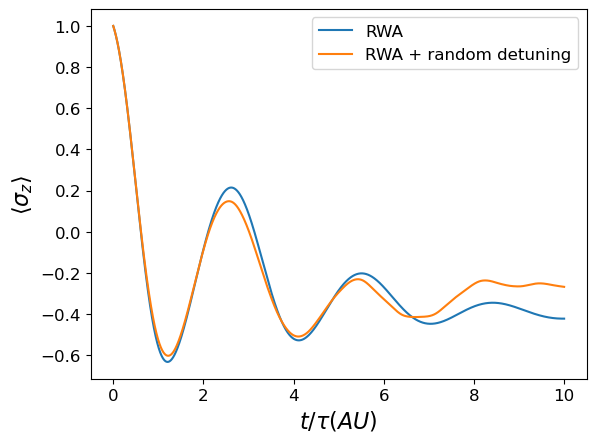

In [63]:
close("all")
pygui(false)

PyPlot.rc("font", size = 12)

plot(T, real(expect(Jz, ρt_RWA))./N, label="RWA")
plot(T, real(expect(Jz, ρt_RWA_det))./N, label="RWA + random detuning")

xlabel(L"t/\tau (AU)", fontsize=16)
ylabel(L"\langle\sigma_z\rangle", fontsize=16)
legend()

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/RO_CS_random_detuning_frequency.pdf", bbox_inches="tight")


gcf()

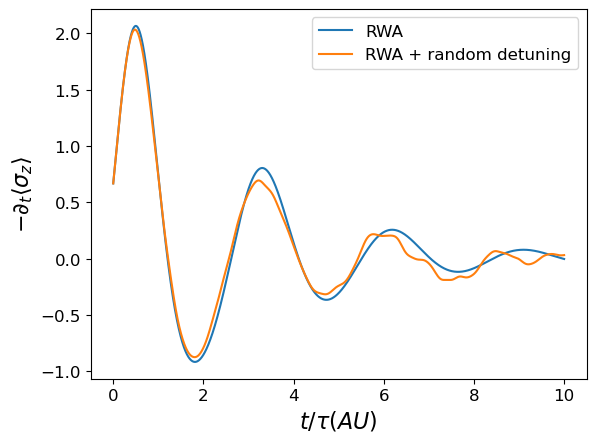

In [64]:
close("all")
pygui(false)

PyPlot.rc("font", size = 12)

plot(T[1:end-1], -diff(real(expect(Jz, ρt_RWA))./N)./Tstep, label="RWA")
plot(T[1:end-1], -diff(real(expect(Jz, ρt_RWA_det))./N)./Tstep, label="RWA + random detuning")

xlabel(L"t/\tau (AU)", fontsize=16)
ylabel(L"-\partial_t\langle\sigma_z\rangle", fontsize=16)
legend()

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/RO_CS_diff_random_detuning.pdf", bbox_inches="tight")


gcf()